In [2]:
#!/usr/bin/env python3
from diffwave.inference import predict as diffwave_predict
import torch
import numpy as np
import torchaudio
import soundfile as sf
import librosa
from pymcd.mcd import Calculate_MCD
from pystoi import stoi
from pesq import pesq
import time
import gc
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set CUDA device and create results directory
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
Path("benchmark_results_chunked").mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current GPU: {torch.cuda.get_device_name()}")


Libraries imported successfully!
CUDA available: True
Current GPU: NVIDIA GeForce RTX 3090


In [3]:
def find_silence_boundaries(mel_spectrogram, silence_threshold_db=-40, min_silence_frames=5):
    """Find silence regions in mel spectrogram for smart chunking boundaries"""
    energy_per_frame = torch.mean(mel_spectrogram, dim=1).squeeze()  # Average energy across mel bins
    energy_db = (energy_per_frame * 100) - 100  # Convert [0,1] back to [-100,0] dB range
    
    # Find silent frames
    silent_frames = energy_db < silence_threshold_db
    
    # Find silence regions (consecutive silent frames)
    silence_boundaries = []
    in_silence = False
    silence_start = 0
    
    for i, is_silent in enumerate(silent_frames):
        if is_silent and not in_silence:
            silence_start = i
            in_silence = True
        elif not is_silent and in_silence:
            silence_length = i - silence_start
            if silence_length >= min_silence_frames:
                boundary = silence_start + silence_length // 2
                silence_boundaries.append(boundary)
            in_silence = False
    
    # Handle case where spectrogram ends in silence
    if in_silence:
        silence_length = len(silent_frames) - silence_start
        if silence_length >= min_silence_frames:
            boundary = silence_start + silence_length // 2
            silence_boundaries.append(boundary)
    
    # Always include start and end
    if 0 not in silence_boundaries:
        silence_boundaries.insert(0, 0)
    if len(energy_per_frame) not in silence_boundaries:
        silence_boundaries.append(len(energy_per_frame))
    
    return sorted(silence_boundaries)

def smart_chunked_predict(mel_spectrogram, model_dir, max_chunk_frames=512, fast_sampling=True, verbose=False):
    """Smart chunked inference using silence boundaries for natural phoneme chunking"""
    if verbose:
        print("=== Smart Phoneme-Based Chunked Inference ===")
        print(f"Input mel shape: {mel_spectrogram.shape}")
    
    # Find natural silence boundaries
    boundaries = find_silence_boundaries(mel_spectrogram, silence_threshold_db=-40, min_silence_frames=5)
    
    # Create chunks between boundaries
    chunks = []
    for i in range(len(boundaries) - 1):
        chunk_start = boundaries[i]
        chunk_end = boundaries[i + 1]
        
        if chunk_start >= chunk_end:
            continue
            
        chunk_size = chunk_end - chunk_start
        
        if chunk_size <= max_chunk_frames:
            chunks.append((chunk_start, chunk_end))
        else:
            # Split large chunks
            current_start = chunk_start
            while current_start + max_chunk_frames < chunk_end:
                chunks.append((current_start, current_start + max_chunk_frames))
                current_start += max_chunk_frames
            if current_start < chunk_end:
                chunks.append((current_start, chunk_end))
    
    if verbose:
        print(f"Found {len(boundaries)} silence boundaries")
        print(f"Created {len(chunks)} smart chunks")
    
    # Process each chunk
    audio_segments = []
    sample_rate = None
    
    start_time = time.time()
    
    for i, (start_frame, end_frame) in enumerate(chunks):
        if verbose:
            print(f"Processing chunk {i+1}/{len(chunks)}: frames {start_frame}-{end_frame}")
        
        mel_chunk = mel_spectrogram[:, :, start_frame:end_frame]
        audio_chunk, sr = diffwave_predict(mel_chunk, model_dir, fast_sampling=fast_sampling)
        
        if sample_rate is None:
            sample_rate = sr
            
        audio_segments.append(audio_chunk.squeeze().cpu())
        del mel_chunk, audio_chunk
    
    torch.cuda.synchronize()
    combined_audio = torch.cat(audio_segments, dim=0)
    
    total_time = time.time() - start_time
    if verbose:
        print(f"Total processing time: {total_time:.3f}s")
        print(f"Final audio shape: {combined_audio.shape}")
    
    return combined_audio.unsqueeze(0), sample_rate

print("Smart chunked inference functions defined!")


Smart chunked inference functions defined!


In [4]:
def benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial_num, max_chunk_frames=512):
    """Benchmark a single chunked inference trial"""
    print(f"  Trial {trial_num}: Processing {mel_file}")
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Load mel spectrogram
    mel_data = torch.from_numpy(np.load(mel_file)).float().unsqueeze(0).to('cuda')
    
    # Measure inference
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    
    audio, sample_rate = smart_chunked_predict(
        mel_data, model_dir, max_chunk_frames=max_chunk_frames, fast_sampling=True, verbose=False
    )
    
    torch.cuda.synchronize()
    end_time = time.time()
    
    inference_time = end_time - start_time
    peak_memory = torch.cuda.max_memory_allocated() / 1024 / 1024  # MB
    
    # Save generated audio
    output_file = f"benchmark_results_chunked/generated_{duration_name}_trial{trial_num}.wav"
    audio_for_save = audio.squeeze().cpu()
    torchaudio.save(output_file, audio_for_save.unsqueeze(0), sample_rate)
    
    # Calculate audio duration and RTF
    audio_duration = len(audio_for_save) / sample_rate
    rtf = inference_time / audio_duration
    
    # Calculate quality metrics
    try:
        # MCD
        mcd_toolbox = Calculate_MCD(MCD_mode="dtw")
        mcd_value = mcd_toolbox.calculate_mcd(audio_file, output_file)
        
        # Load audio for STOI and PESQ
        original_audio, sr_orig = sf.read(audio_file)
        generated_audio, sr_gen = sf.read(output_file)
        
        if sr_orig != sr_gen:
            generated_audio = librosa.resample(y=generated_audio, orig_sr=sr_gen, target_sr=sr_orig)
        
        min_len = min(len(original_audio), len(generated_audio))
        original_audio = original_audio[:min_len]
        generated_audio = generated_audio[:min_len]
        
        # STOI
        stoi_score = stoi(original_audio, generated_audio, sr_orig, extended=False)
        
        # WB-PESQ - Use first 60s for long audio due to library limitations (same as regular benchmark)
        if audio_duration >= 120.0:
            max_samples_60s = int(60.0 * sr_orig)
            original_for_pesq = original_audio[:max_samples_60s]
            generated_for_pesq = generated_audio[:max_samples_60s]
            print(f"    PESQ calculated on first 60s (original audio: {audio_duration:.1f}s)")
        else:
            original_for_pesq = original_audio
            generated_for_pesq = generated_audio
        
        sr_pesq = 16000
        original_16k = librosa.resample(y=original_for_pesq, orig_sr=sr_orig, target_sr=sr_pesq)
        generated_16k = librosa.resample(y=generated_for_pesq, orig_sr=sr_orig, target_sr=sr_pesq)
        wb_pesq_score = pesq(sr_pesq, original_16k, generated_16k, 'wb')
        
    except Exception as e:
        print(f"    Error calculating quality metrics: {e}")
        mcd_value = np.nan
        stoi_score = np.nan
        wb_pesq_score = np.nan
    
    # Cleanup
    del mel_data, audio
    torch.cuda.empty_cache()
    
    print(f"    Inference: {inference_time:.3f}s, RTF: {rtf:.3f}, Memory: {peak_memory:.1f}MB")
    
    return {
        'inference_time_s': inference_time,
        'audio_duration_s': audio_duration, 
        'rtf': rtf,
        'peak_memory_mb': peak_memory,
        'mcd': mcd_value,
        'stoi': stoi_score,
        'wb_pesq': wb_pesq_score,
        'duration_name': duration_name,
        'trial': trial_num,
        'audio_file': audio_file,
        'mel_file': mel_file
    }

print("Benchmarking functions defined!")


Benchmarking functions defined!


In [5]:
# Configuration
model_dir = 'diffwave-ljspeech-22kHz-1000578.pt'
results = []  # Store all results

print("Configuration set!")
print("Ready to run chunked inference benchmarking")
print("Note: Run each duration cell separately to avoid memory issues")


Configuration set!
Ready to run chunked inference benchmarking
Note: Run each duration cell separately to avoid memory issues


In [6]:
# Test 1s duration
duration_name = "1s"
audio_file = "audio/1s.wav"
mel_file = "audio/1s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 1s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/1s_mel.npy
    Inference: 0.550s, RTF: 0.521, Memory: 76.5MB
✓ 1s Trial 1 completed successfully
  Trial 2: Processing audio/1s_mel.npy
    Inference: 0.092s, RTF: 0.087, Memory: 56.9MB
✓ 1s Trial 2 completed successfully
  Trial 3: Processing audio/1s_mel.npy
    Inference: 0.092s, RTF: 0.088, Memory: 56.9MB
✓ 1s Trial 3 completed successfully
Completed 1s benchmarking. Results so far: 3


In [7]:
# Test 5s duration
duration_name = "5s"
audio_file = "audio/5s.wav"
mel_file = "audio/5s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 5s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/5s_mel.npy


    Inference: 0.384s, RTF: 0.074, Memory: 205.5MB
✓ 5s Trial 1 completed successfully
  Trial 2: Processing audio/5s_mel.npy
    Inference: 0.377s, RTF: 0.072, Memory: 205.5MB
✓ 5s Trial 2 completed successfully
  Trial 3: Processing audio/5s_mel.npy
    Inference: 0.378s, RTF: 0.072, Memory: 205.5MB
✓ 5s Trial 3 completed successfully
Completed 5s benchmarking. Results so far: 6


In [8]:
# Test 15s duration
duration_name = "15s"
audio_file = "audio/15s.wav"
mel_file = "audio/15s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 15s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/15s_mel.npy


    Inference: 1.117s, RTF: 0.072, Memory: 443.6MB
✓ 15s Trial 1 completed successfully
  Trial 2: Processing audio/15s_mel.npy
    Inference: 1.081s, RTF: 0.069, Memory: 443.6MB
✓ 15s Trial 2 completed successfully
  Trial 3: Processing audio/15s_mel.npy
    Inference: 1.082s, RTF: 0.069, Memory: 443.6MB
✓ 15s Trial 3 completed successfully
Completed 15s benchmarking. Results so far: 9


In [9]:
# Test 30s duration
duration_name = "30s"
audio_file = "audio/30s.wav"
mel_file = "audio/30s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 30s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/30s_mel.npy
    Inference: 2.102s, RTF: 0.069, Memory: 444.0MB
✓ 30s Trial 1 completed successfully
  Trial 2: Processing audio/30s_mel.npy
    Inference: 2.084s, RTF: 0.069, Memory: 444.0MB
✓ 30s Trial 2 completed successfully
  Trial 3: Processing audio/30s_mel.npy
    Inference: 2.084s, RTF: 0.069, Memory: 444.0MB
✓ 30s Trial 3 completed successfully
Completed 30s benchmarking. Results so far: 12


In [10]:
# Test 60s duration
duration_name = "60s"
audio_file = "audio/60s.wav"
mel_file = "audio/60s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 60s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/60s_mel.npy


    Inference: 4.199s, RTF: 0.069, Memory: 444.7MB
✓ 60s Trial 1 completed successfully
  Trial 2: Processing audio/60s_mel.npy
    Inference: 4.159s, RTF: 0.069, Memory: 444.7MB
✓ 60s Trial 2 completed successfully
  Trial 3: Processing audio/60s_mel.npy
    Inference: 4.165s, RTF: 0.069, Memory: 444.7MB
✓ 60s Trial 3 completed successfully
Completed 60s benchmarking. Results so far: 15


In [11]:
# Test 120s duration
duration_name = "120s"
audio_file = "audio/120s.wav"
mel_file = "audio/120s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 120s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/120s_mel.npy
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 8.305s, RTF: 0.069, Memory: 446.3MB
✓ 120s Trial 1 completed successfully
  Trial 2: Processing audio/120s_mel.npy
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 8.186s, RTF: 0.068, Memory: 446.3MB
✓ 120s Trial 2 completed successfully
  Trial 3: Processing audio/120s_mel.npy
    PESQ calculated on first 60s (original audio: 120.4s)
    Inference: 8.189s, RTF: 0.068, Memory: 446.3MB
✓ 120s Trial 3 completed successfully
Completed 120s benchmarking. Results so far: 18


In [12]:
# Test 240s duration
duration_name = "240s"
audio_file = "audio/240s.wav"
mel_file = "audio/240s_mel.npy"

for trial in range(1, 4):
    try:
        result = benchmark_chunked_inference(mel_file, audio_file, model_dir, duration_name, trial)
        results.append(result)
        print(f"✓ {duration_name} Trial {trial} completed successfully")
    except Exception as e:
        print(f"✗ {duration_name} Trial {trial} failed: {e}")
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"Completed 240s benchmarking. Results so far: {len(results)}")


  Trial 1: Processing audio/240s_mel.npy


    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 16.677s, RTF: 0.069, Memory: 449.5MB
✓ 240s Trial 1 completed successfully
  Trial 2: Processing audio/240s_mel.npy
    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 16.440s, RTF: 0.068, Memory: 449.5MB
✓ 240s Trial 2 completed successfully
  Trial 3: Processing audio/240s_mel.npy
    PESQ calculated on first 60s (original audio: 240.4s)
    Inference: 16.414s, RTF: 0.068, Memory: 449.5MB
✓ 240s Trial 3 completed successfully
Completed 240s benchmarking. Results so far: 21


In [13]:
# Convert to DataFrame and save detailed results
df = pd.DataFrame(results)
df.to_csv('diffwave_chunked_benchmark_results.csv', index=False)
print(f"Saved detailed results: {len(results)} trials")

# Calculate summary statistics exactly like regular benchmark
summary_stats = df.groupby('duration_name').agg({
    'inference_time_s': ['mean', 'std'],
    'audio_duration_s': ['mean', 'std'],
    'rtf': ['mean', 'std'],
    'peak_memory_mb': ['mean', 'std'],
    'mcd': ['mean', 'std'],
    'stoi': ['mean', 'std'],
    'wb_pesq': ['mean', 'std']
}).round(3)

# Create formatted output exactly like regular benchmark
duration_order = ['1s', '5s', '15s', '30s', '60s', '120s', '240s']
summary_formatted = []

for duration in duration_order:
    if duration in summary_stats.index:
        row_data = summary_stats.loc[duration]
        formatted_row = {
            'Duration': duration,
            'inference_time_s': f"{row_data[('inference_time_s', 'mean')]:.3f} ± {row_data[('inference_time_s', 'std')]:.3f}",
            'audio_duration_s': f"{row_data[('audio_duration_s', 'mean')]:.3f} ± {row_data[('audio_duration_s', 'std')]:.3f}",
            'rtf': f"{row_data[('rtf', 'mean')]:.3f} ± {row_data[('rtf', 'std')]:.3f}",
            'peak_memory_mb': f"{row_data[('peak_memory_mb', 'mean')]:.3f} ± {row_data[('peak_memory_mb', 'std')]:.3f}",
            'mcd': f"{row_data[('mcd', 'mean')]:.3f} ± {row_data[('mcd', 'std')]:.3f}",
            'stoi': f"{row_data[('stoi', 'mean')]:.3f} ± {row_data[('stoi', 'std')]:.3f}",
            'wb_pesq': f"{row_data[('wb_pesq', 'mean')]:.3f} ± {row_data[('wb_pesq', 'std')]:.3f}"
        }
        summary_formatted.append(formatted_row)

# Save summary in same format as regular benchmark
summary_df = pd.DataFrame(summary_formatted)
summary_df.set_index('Duration', inplace=True)
summary_df.to_csv('diffwave_chunked_benchmark_summary.csv')

print("\n=== CHUNKED INFERENCE SUMMARY ===")
print(summary_df)

print(f"\nFiles saved:")
print(f"- diffwave_chunked_benchmark_results.csv (detailed results)")
print(f"- diffwave_chunked_benchmark_summary.csv (summary statistics)")


Saved detailed results: 21 trials

=== CHUNKED INFERENCE SUMMARY ===
         inference_time_s audio_duration_s            rtf   peak_memory_mb  \
Duration                                                                     
1s          0.245 ± 0.264    1.057 ± 0.000  0.232 ± 0.250  63.407 ± 11.325   
5s          0.380 ± 0.004    5.224 ± 0.000  0.073 ± 0.001  205.484 ± 0.000   
15s         1.093 ± 0.020   15.604 ± 0.000  0.070 ± 0.001  443.567 ± 0.000   
30s         2.090 ± 0.010   30.360 ± 0.000  0.069 ± 0.000  443.956 ± 0.000   
60s         4.174 ± 0.022   60.546 ± 0.000  0.069 ± 0.000  444.749 ± 0.000   
120s        8.227 ± 0.067  120.361 ± 0.000  0.068 ± 0.001  446.321 ± 0.000   
240s       16.510 ± 0.145  240.361 ± 0.000  0.069 ± 0.001  449.476 ± 0.000   

                    mcd           stoi        wb_pesq  
Duration                                               
1s        0.997 ± 0.052  0.864 ± 0.019  1.797 ± 0.522  
5s        2.206 ± 0.068  0.920 ± 0.009  2.382 ± 0.045  
15s 

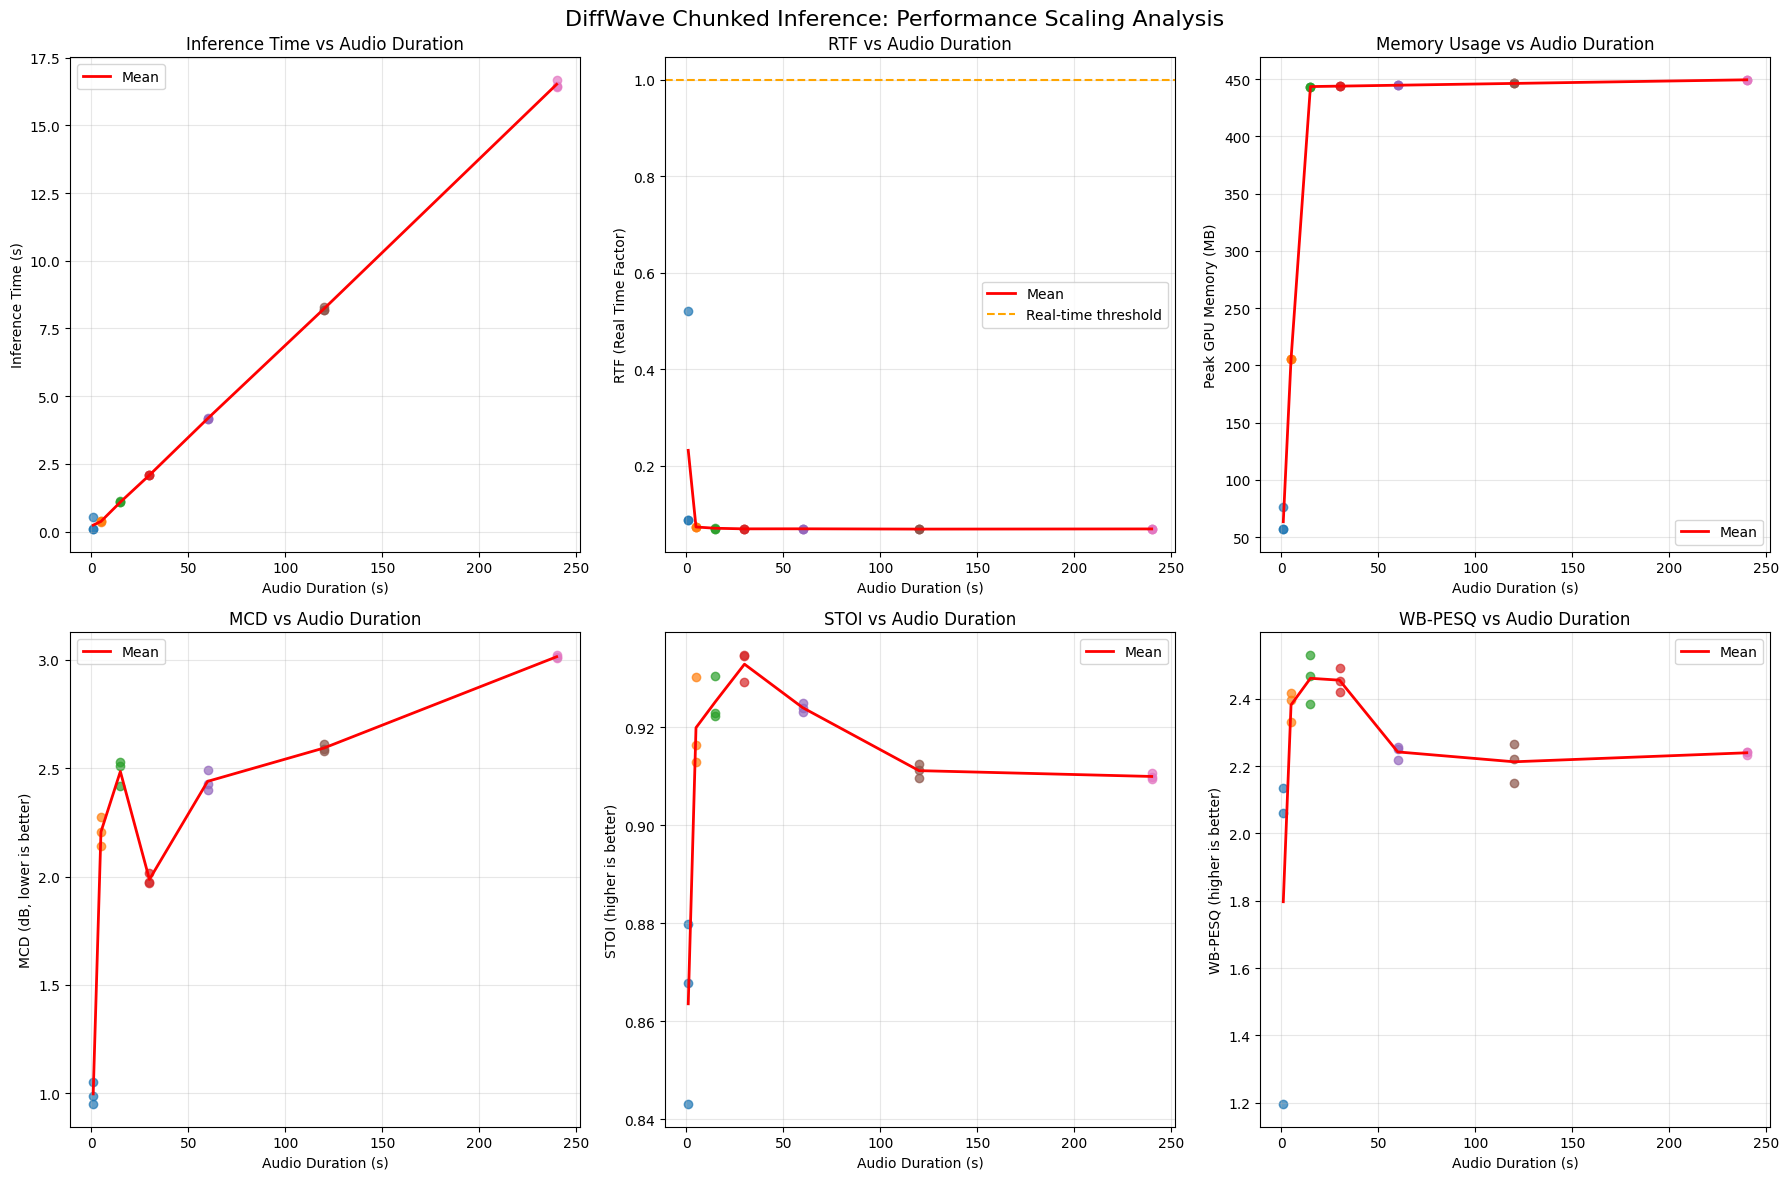

Performance analysis plots saved as: diffwave_chunked_benchmark_analysis.png


In [14]:
# Create visualization of scaling relationships - EXACT SAME AS REGULAR BENCHMARK
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DiffWave Chunked Inference: Performance Scaling Analysis', fontsize=16)

# Convert duration names to numeric for plotting
duration_numeric = [int(d.replace('s', '')) for d in df['duration_name']]
df['duration_numeric'] = duration_numeric

# Plot 1: Inference Time vs Audio Length
ax = axes[0, 0]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['inference_time_s'], alpha=0.7)

# Plot mean line
means = df.groupby('duration_numeric')['inference_time_s'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('Inference Time (s)')
ax.set_title('Inference Time vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: RTF vs Audio Length
ax = axes[0, 1]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['rtf'], alpha=0.7)

means = df.groupby('duration_numeric')['rtf'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.axhline(y=1.0, color='orange', linestyle='--', label='Real-time threshold')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('RTF (Real Time Factor)')
ax.set_title('RTF vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Peak Memory vs Audio Length
ax = axes[0, 2]
for duration in sorted(df['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = df[df['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['peak_memory_mb'], alpha=0.7)

means = df.groupby('duration_numeric')['peak_memory_mb'].mean()
ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('Peak GPU Memory (MB)')
ax.set_title('Memory Usage vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: MCD vs Audio Length
ax = axes[1, 0]
valid_mcd = df.dropna(subset=['mcd'])
for duration in sorted(valid_mcd['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_mcd[valid_mcd['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['mcd'], alpha=0.7)

if not valid_mcd.empty:
    means = valid_mcd.groupby('duration_numeric')['mcd'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('MCD (dB, lower is better)')
ax.set_title('MCD vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: STOI vs Audio Length
ax = axes[1, 1]
valid_stoi = df.dropna(subset=['stoi'])
for duration in sorted(valid_stoi['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_stoi[valid_stoi['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['stoi'], alpha=0.7)

if not valid_stoi.empty:
    means = valid_stoi.groupby('duration_numeric')['stoi'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('STOI (higher is better)')
ax.set_title('STOI vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: WB-PESQ vs Audio Length
ax = axes[1, 2]
valid_pesq = df.dropna(subset=['wb_pesq'])
for duration in sorted(valid_pesq['duration_name'].unique(), key=lambda x: int(x.replace('s', ''))):
    subset = valid_pesq[valid_pesq['duration_name'] == duration]
    ax.scatter([int(duration.replace('s', ''))] * len(subset), subset['wb_pesq'], alpha=0.7)

if not valid_pesq.empty:
    means = valid_pesq.groupby('duration_numeric')['wb_pesq'].mean()
    ax.plot(means.index, means.values, 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('WB-PESQ (higher is better)')
ax.set_title('WB-PESQ vs Audio Duration')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diffwave_chunked_benchmark_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Performance analysis plots saved as: diffwave_chunked_benchmark_analysis.png")


NameError: name 'summary_formatted' is not defined

NameError: name 'results' is not defined